In [ ]:
# Bi-lstm test, based on
# https://medium.com/illuin/named-entity-recognition-with-bilstm-cnns-632ba83d3d41
# https://www.kaggle.com/navya098/bi-lstm-for-ner

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
dframe = pd.read_csv("./Other/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)
dframe.head()

b'Skipping line 281837: expected 25 fields, saw 34\n'


,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [4]:
dataset=dframe.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word',"pos", "shape"],axis=1)
display(dataset.head())
dataset.info()

,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050795 entries, 0 to 1050794
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   sentence_idx  1050794 non-null  float64
 1   word          1050794 non-null  object 
 2   tag           1050794 non-null  object 
dtypes: float64(1), object(2)
memory usage: 24.1+ MB


In [5]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [6]:
getter = SentenceGetter(dataset)
sentences = getter.sentences
print(sentences[5])

[('The', 'O'), ('party', 'O'), ('is', 'O'), ('divided', 'O'), ('over', 'O'), ('Britain', 'B-gpe'), ("'s", 'O'), ('participation', 'O'), ('in', 'O'), ('the', 'O'), ('Iraq', 'B-geo'), ('conflict', 'O'), ('and', 'O'), ('the', 'O'), ('continued', 'O'), ('deployment', 'O'), ('of', 'O'), ('8,500', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('in', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O'), ('The', 'O'), ('party', 'O'), ('is', 'O'), ('divided', 'O'), ('over', 'O'), ('Britain', 'B-gpe'), ("'s", 'O'), ('participation', 'O'), ('in', 'O'), ('the', 'O'), ('Iraq', 'B-geo'), ('conflict', 'O'), ('and', 'O'), ('the', 'O'), ('continued', 'O'), ('deployment', 'O'), ('of', 'O'), ('8,500', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('in', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [7]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 140


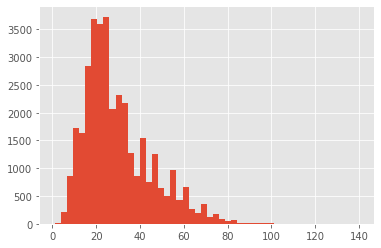

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [9]:
words = list(set(dataset["word"].values))
words.append("ENDPAD")

In [10]:
#Count how many words there are 

n_words = len(words)
n_words

30174

In [11]:
tags = list(set(dataset["tag"].values))
n_tags = len(tags)
n_tags


18

In [12]:
# Convert to indices, use a dict
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [13]:
word2idx['Cat']

22910

In [14]:
tag2idx["O"]

2

In [15]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=140, sequences=X, padding="post",value=n_words - 1)
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=140, sequences=y, padding="post", value=tag2idx["O"])


Using TensorFlow backend.


In [16]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [18]:
np.array(y_train).shape

(28141, 140, 18)

In [19]:
from keras.models import Model, Input

from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [20]:
X_train.shape
y_train[0].shape

#For each sentence, output has shape 140 x 18
# The full label matrix has shape SENTENCE_IDX, WORD_IDX, ONE_HOT_ENCODED_CLASS
#                                        2000x140,18

OUT_DIM = y_train[0].shape[1]
IN_DIM = TOKENS_IN_SENTENCE = X_train.shape[1]
n_words = len(words)


In [21]:
print(X_train.shape)
print(np.array(y_train).shape)


(28141, 140)
(28141, 140, 18)


In [22]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import torch
from tqdm import tqdm, trange
from transformers import AutoModel
from keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

df = pd.read_pickle("../data/sentence_labels")

#Work on a subset for testing purposes
input_df = df[['Sentence']].head(20000).copy()
label_df = df[['Labels']].head(20000).copy()

#Load swedish tokenizer
tokenizer = AutoTokenizer.from_pretrained("KB/bert-base-swedish-cased-ner")

# Use WORDPIECE tokenization
#input_df['Tokenized'] = input_df[['Sentence']].apply(lambda x: tokenizer.tokenize(x[0]), axis=1)
# Ensure no named entities have been split apart

# use WORD tokenization
input_df['Tokenized'] = input_df[['Sentence']].apply(lambda x: x[0], axis=1)

# Replace words with integers, add the special [CLS] and [SEP] tokens
input_df['Integerized'] = input_df[['Tokenized']].apply(lambda x: tokenizer.encode(x[0], add_special_tokens=True), axis=1)

# Pad and truncate all sentences so they are the same length
length = 50
input_df['Input'] = input_df[['Integerized']].apply(lambda x: pad_sequences(x, maxlen=length, dtype="long", truncating="post", padding="post")[0],       axis=1)


In [23]:
input_data = np.array([x[0] for x in input_df[['Input']].values])

In [24]:
label_df['Tokenized'] = label_df[['Labels']].apply(lambda x: x[0], axis=1)

# Replace labels with integers, add the special [CLS] and [SEP] tokens
label_df['Integerized'] = label_df[['Tokenized']].apply(lambda x: tokenizer.encode(x[0], add_special_tokens=True), axis=1)

# Pad and truncate all labels so they are the same length
length = 50
label_df['Output_Class'] = label_df[['Integerized']].apply(lambda x: pad_sequences(x, maxlen=length, dtype="long", truncating="post",                    padding="post")[0], axis=1)

#Create the output_class matrix. Doesn't need to be a tensor, since it won't go into BERT
label_matrix = np.array([x[0] for x in label_df[['Output_Class']].values])

In [25]:
output_data = np.array(pd.get_dummies(label_matrix.reshape(-1,))).reshape(label_matrix.shape[0], label_matrix.shape[1], -1)

In [44]:
print(input_data.shape, output_data.shape)
print(input_data[0])
print(output_data[0])

(20000, 50) (20000, 50, 9)
[    2   135   243   578 10540    68  3380  7245 49796 27689 28413 26922
 49796  3206   121  3393  4634 49796  2901  6697   116    48    98   346
 31843 24926   671  4958   237   541    66  9926 21667    36 16370 15191
    42   696    98     7     3     0     0     0     0     0     0     0
     0     0]
[[0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 

In [47]:
print(X_train.shape)
print(y_train.shape)
print(X_train[0])
print(y_train[0])

(28141, 140)
(28141, 140, 18)
[14162 15448 26539 14287 30017  3349  6988  9167  2921 20415  6975 15448
 26060 20079  3800 15969 20828 22813  1427  9167  1269 17011  2198 26060
  7420 29057 28181 30017 22041 22133 24033 14162 15448 26539 14287 30017
  3349  6988  9167  2921 20415  6975 15448 26060 20079  3800 15969 20828
 22813  1427  9167  1269 17011  2198 26060  7420 29057 28181 30017 22041
 22133 24033 30173 30173 30173 30173 30173 30173 30173 30173 30173 30173
 30173 30173 30173 30173 30173 30173 30173 30173 30173 30173 30173 30173
 30173 30173 30173 30173 30173 30173 30173 30173 30173 30173 30173 30173
 30173 30173 30173 30173 30173 30173 30173 30173 30173 30173 30173 30173
 30173 30173 30173 30173 30173 30173 30173 30173 30173 30173 30173 30173
 30173 30173 30173 30173 30173 30173 30173 30173 30173 30173 30173 30173
 30173 30173 30173 30173 30173 30173 30173 30173]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. .

In [58]:
output_data[0].shape
y_train[0].shape

(140, 18)

In [60]:
y_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [39]:
def bilstm_x():
    # The input is two-dimensional. Each row is a sentence. Each column is a word in the sentence.

#For the model, each datapoint is thus a 140-dimensional input 

    input = Input(shape=(50,))
    model = Embedding(input_dim=40441, output_dim=output_data[2], input_length=50)(input)
    model = Dropout(0.1)(model)
    model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
    out = TimeDistributed(Dense(output_data[2], activation="softmax"))(model)  # softmax output layer
    model = Model(input, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model


print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 140, 18)           543132    
_________________________________________________________________
dropout_2 (Dropout)          (None, 140, 18)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 140, 200)          95200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 140, 18)           3618      
Total params: 641,950
Trainable params: 641,950
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
model = bilstm_x()
model.fit(input_data, output_data, batch_size=16, epochs=1, validation_split=0.2, verbose=1)


ValueError: Can't convert Python sequence with mixed types to Tensor.

In [28]:
def evaluate_models(list_of_models):
    for model in list_of_models:
        #Train it
        print(model.summary())
        model.fit(X_train, np.array(y_train), batch_size=16, epochs=1, validation_split=0.2, verbose=1)

        print('\n# Evaluate on test data')
        results = model.evaluate(np.array(X_test), np.array(y_test))
        for i, metric in enumerate(model.metrics_names):
            print(f"{metric}: {results[i]}")

In [38]:
print(TOKENS_IN_SENTENCE, n_words, OUT_DIM)

140 30174 18


In [30]:
def bilstm_1():
    # The input is two-dimensional. Each row is a sentence. Each column is a word in the sentence.

#For the model, each datapoint is thus a 140-dimensional input 

    input = Input(shape=(TOKENS_IN_SENTENCE,))
    model = Embedding(input_dim=n_words, output_dim=OUT_DIM, input_length=TOKENS_IN_SENTENCE)(input)
    model = Dropout(0.1)(model)
    model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
    out = TimeDistributed(Dense(OUT_DIM, activation="softmax"))(model)  # softmax output layer
    model = Model(input, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model


print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 140, 18)           543132    
_________________________________________________________________
dropout_1 (Dropout)          (None, 140, 18)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 140, 200)          95200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 140, 18)           3618      
Total params: 641,950
Trainable params: 641,950
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
model = bilstm_1()
model.fit(X_train, y_train, batch_size=16, epochs=1, validation_split=0.2, verbose=1)


/home/vic/git/thesis/.thesis/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22512 samples, validate on 5629 samples
Epoch 1/1
22512/22512 [==============================] - 289s 13ms/step - loss: 0.1253 - accuracy: 0.9731 - val_loss: 0.0604 - val_accuracy: 0.9827


In [33]:
print('\n# Evaluate on test data')
results = model.evaluate(np.array(X_test), np.array(y_test))
for i, metric in enumerate(model.metrics_names):
    print(f"{metric}: {results[i]}")


# Evaluate on test data
7036/7036 [==============================] - 17s 2ms/step
loss: 0.0614988464330529
accuracy: 0.9821895360946655


In [ ]:
X_train.shape

In [ ]:
def evaluate_models(list_of_models):
    for model in list_of_models:
        #Train it
        print(model.summary())
        model.fit(X_train, np.array(y_train), batch_size=16, epochs=1, validation_split=0.2, verbose=1)

        print('\n# Evaluate on test data')
        results = model.evaluate(np.array(X_test), np.array(y_test))
        for i, metric in enumerate(model.metrics_names):
            print(f"{metric}: {results[i]}")

In [ ]:
print(X_train.shape)
print(np.array(y_train).shape)

In [ ]:

to_test = [m1,m2, m3, m4]
evaluate_models(to_test)

In [ ]:
evaluate_models(model)

In [ ]:
i = 1
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:14}: {}".format(words[w],tags[pred]))